In [158]:
from imap_functions_PRISMA import *
import matplotlib.pyplot as plt


##### EXAMPLE RETRIEVAL FOR SCENE OVER SAN JUAN POWER PLANT


#Load data
class args:
    pass

args.direc = 'prs20200731t181747_SanJuan'
args.name = 'prs20200731t181747_SanJuan'
args.lat = 36.793
args.lon = 108.391
args.source = 'SanJuan'

#Using meteorological fields and HITRAN cross-sections precomputed from a different
#scene. They should work fine for illustration
args.met = 'prs20200615t182416_Hunter'
args.hitran = 'prs20200615t182416_Hunter'


#Set up the retrieval
init_dict = {'rad_dir': args.direc,\
             'rad_name': args.name,\
             'main': '/Users/cusworth/Documents/PRISMA/FullScenes/SanJuan/',\
             'wave_pos': 'ancillary/prisma_wvl.txt',\
             'alt_agl_km': 500,\
             'latitude': float(args.lat),\
             'longitude': -1*float(args.lon),\
             'fwhm': 5,\
             'SNR': 200,\
             'deg_poly': 6,\
             'do_legendre': False, \
             'met_file':'met/merra_met'+ args.met + '.p',\
             'inversion_wvl': [1920, 2130], \
             'hitran_loaded': args.hitran}


#Load image and data
files, set_inputs, wave_class, set_flight, coord_sub = initialize(init_dict)
met = load_met(set_inputs, set_flight, files)
cs, met, wave_class = load_hitran_solar(wave_class, met, files)
rgb, rad_sub, wave_class, met = load_raw_observations(files, set_inputs, wave_class, met, cs)


In [159]:
### Retrieval equations - in the more operational code, this is called "run_retrieval2"

#~~~~ INDICES IN DATA CUBE TO PLAY AROUND WITH ~~~~~
idx = 50
jdx = 60

#Run retrieval given indices
Y = rad_sub[idx,jdx,:] / .1
Y = Y[wave_class.wvl_sel]

inv_prms = make_class()

#Prior start of polynomial fit is fit to subsample of Y
init_k = set_inputs.deg_poly
YT = Y/met.T_lo_0

hi_x = np.linspace(-1, 1, len(wave_class.wvl_hi))
lo_x = interpolate.interp1d(np.flip(wave_class.wvl_hi), hi_x)(wave_class.wvl_lo)

#Set target wavelengths for low frequency features for CO2 retrieval
zero_wvls = [1904, 1914, 1923, 1932, 1984, 2036, 2094, 2102]
near_zeros = []
for izero in zero_wvls: 
    imatch = np.argmin(np.abs(wave_class.wvl_lo - izero))
    near_zeros.append(imatch)
near_zeros = np.array(near_zeros)

#Fit the polynomial
lfit = np.polynomial.polynomial.polyfit(lo_x[near_zeros], Y[near_zeros], init_k)
lval = np.polynomial.polynomial.polyval(hi_x, lfit)
lval_lo = np.polynomial.polynomial.polyval(lo_x, lfit)

#Scaling factors for gases
lCH4 = set_inputs.layers_ch4
lH2O = set_inputs.layers_h2o
lN2O = set_inputs.layers_n2o

#Define first prior
s1 = get_scaling(met.vmr_CH4, met.ch4_red_A, met.bnd_ch4, met.pmid, met.h_full)
s2 = get_scaling(met.vmr_H2O, met.h2o_red_A, met.bnd_h2o, met.pmid, met.h_full)
s3 = get_scaling(met.vmr_N2O, met.n2o_red_A, met.bnd_n2o, met.pmid, met.h_full)

#Set value of first prior + first iteration
xa_full = np.append(s1, np.append(s2, np.append(s3, np.append(wave_class.shift_coef, lfit))))
inv_prms.xa_full = xa_full

#Construct prior error covariance
sig_prior = np.abs(xa_full)  #Error on prior proportional to magnitude

#Methane prior
sig_prior[0] *= .5
if set_inputs.layers_ch4 == 2: #If airbone
    sig_prior[1] *= .5    
sig_prior[(lCH4):(lCH4+lH2O)] *= .5 #H2O prior
sig_prior[(lCH4+lH2O):(lCH4+lH2O+lN2O)] *= 1e-1 #N2O prior
sig_prior[lCH4+lH2O+lN2O] *= 1e-5 #Shift prior
sig_prior[-len(lfit):] *= .5 #polynomial
Sa = np.diag((sig_prior**2))
invSa = np.linalg.inv(Sa)

#Obs error covariance
noise_val = 1/(set_inputs.SNR**2)
invSe = np.diag([1/noise_val] * len(Y))

#Do five iterations - generally this is sufficient
for i_iter in range(5):
    
    if i_iter == 0:
        ix = xa_full
    else:
        ix = x_1

    #Run Forward model
    ilval = np.polynomial.polynomial.polyval(hi_x, ix[-len(lfit):])
    T = np.flip(Transmission(ix[0:(lCH4)], ix[(lCH4):(lCH4+lH2O)], ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)], met, cs))
    Fa = F_lo(Forward3(T, ilval), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
    if i_iter==0:
        Fa_1 = Fa
    
    #Create Jacobian
    K = Make_Jac4(T, lcoefs=ix[-len(lfit):], scoefs=np.array([ix[lCH4+lH2O+lN2O]]), \
            wave_class=wave_class, met=met, set_inputs=set_inputs, cs=cs, \
            sCH4=ix[0:(lCH4)], sH2O=ix[(lCH4):(lCH4+lH2O)], sN2O=ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)])

    #Iterative solution for next state
    term1 = np.linalg.inv(K.T.dot(invSe).dot(K) + invSa)
    term2 = K.T.dot(invSe)
    term3 = (Y - Fa) + K.dot(ix - xa_full)
    x_1 = xa_full + (term1.dot(term2)).dot(term3)

    #Posterior error
    S_1 = np.linalg.inv(K.T.dot(invSe).dot(K)+np.linalg.inv(Sa))
    lval_hat = np.polynomial.polynomial.polyval(hi_x, x_1[-len(lfit):])

#Posterior estimate
sCH4_hat = x_1[0:lCH4]
sH2O_hat = x_1[(lCH4):(lCH4+lH2O)]
sN2O_hat = x_1[(lCH4+lH2O):(lCH4+lH2O+lN2O)]

That = np.flip(Transmission(sCH4_hat, sH2O_hat, sN2O_hat, met, cs))
Fhat = F_lo(Forward3(That, lval_hat), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)

#Output data
inv_prms.Fh = Fhat
inv_prms.Y = Y
inv_prms.Fa = Fa_1
inv_prms.RMSE = np.sqrt(np.mean((Y-Fhat)**2))
inv_prms.ilval = lval_lo
inv_prms.lval_hat = F_lo(lval_hat, np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
inv_prms.K = K
inv_prms.xhat = x_1
inv_prms.Sa = Sa
inv_prms.Sh = S_1
inv_prms.Aker = np.eye(Sa.shape[0]) - S_1.dot(np.linalg.inv(Sa))

retrieved_CO2 = (np.dot(x_1[0:lCH4] * met.ch4_red_A, met.h) * 1e9) / 1000


/Users/cusworth/opt/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [160]:
#Show output

print('Retrieval precision (%)', 100*np.sqrt(S_1[0,0]))
print('Prior precision (%)', 100*np.sqrt(Sa[0,0]))
print('Total XCO2 (ppm)', retrieved_CO2)

Retrieval precision (%) 8.508923814121896
Prior precision (%) 50.0
Total XCO2 (ppm) 487.5233371226509


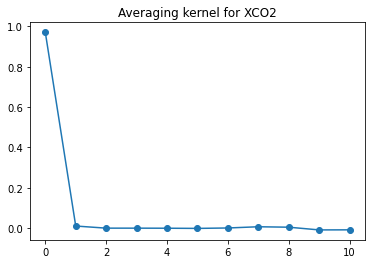

In [161]:
#Plot averaging kernel for CO2
plt.plot(inv_prms.Aker[:,0], 'o-')
plt.title('Averaging kernel for XCO2')
plt.show()

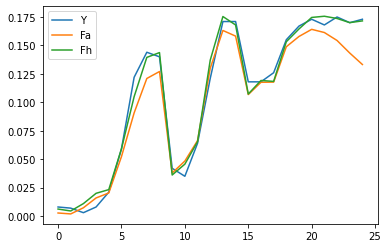

In [162]:
#Plot observed, prior, and posterior spectra

plt.plot(Y, label='Y')
plt.plot(Fa_1, label='Fa')
plt.plot(Fhat, label='Fh')
plt.legend()
plt.show()
